In [3]:
import math
from pynq import Overlay
from PIL import Image as PIL_Image
from PIL import ImageDraw as PIL_ImageDraw
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from pynq import MMIO
#from pynq import Xlnk
import time
import ctypes

## Preparing input images

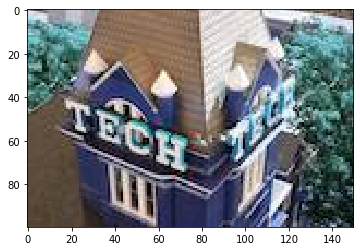

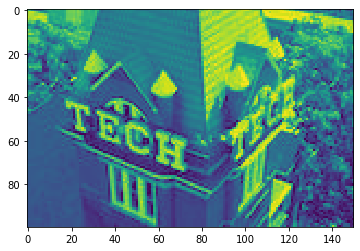

Found 3 Channels : (100, 150, 3)
Converted to Gray Channel. Size : (100, 150)


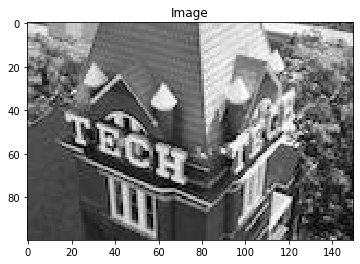

In [4]:
#image path 
ORIG_IMG_PATH   = 'gt_100.jpeg'

image=cv2.imread(ORIG_IMG_PATH)
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image)
plt.show()

plt.imshow(gray)
plt.show()


if len(image.shape) == 3:
    print("Found 3 Channels : {}".format(image.shape))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Converted to Gray Channel. Size : {}".format(image.shape))
else:
    print("Image Shape : {}".format(image.shape))

    print("Kernel Shape : {}".format(kernel.shape))

plt.imshow(image, cmap='gray')
plt.title("Image")
plt.show()


In [7]:
from pynq import (allocate, Overlay)
import numpy as np
ol=Overlay('./convolution.bit')

## you should check whether axi_dma_0 and example_0 are in the ip dict list. 
#ol.ip_dict  

###  Load Bitstreamd and overlay

In [8]:
def fpga_convolution(image,kernel, ol):
    
    ###  Creat DMA instances 
    ##  Using the labels for the DMAs listed above, we can create two DMA objects.
    ol.axi_dma_0?


    dma = ol.axi_dma_0
    dma_send = ol.axi_dma_0.sendchannel
    dma_recv = ol.axi_dma_0.recvchannel

    example_ip=ol.example_0

    ## comment out hlep but initially you wnat to check whether example ip exists 
    # help(example_ip)
    ## Pack kernel first as 1D 
    
    ## flatten kernel and convert float as a fixed input 
    kernel_row, kernel_col = kernel.shape
    kernel_size = kernel_row * kernel_col 
    kernel_1D = allocate(shape=(kernel_size,), dtype=np.int32)
    
    ## initialize kernel with I 
    for i in range (kernel_row):
        for j in range (kernel_col):
            kernel_1D[i*kernel_col+j] = kernel[i,j]*1000
        
    
    
    image_row, image_col = image.shape
    
    ## now we need to tell that we are starting 
    image_size = image_row * image_col 
    
    ## prepare 1D-image array 
    input_image = allocate(shape=(image_size,), dtype=np.int32)
    
    ## prepare data to send 
    send_data = allocate(shape=(image_size+kernel_size,), dtype=np.int32)
   
    # prepare output image array 
    output_image = allocate(shape=(image_size,), dtype=np.int32)
    
    ## prepare data to receive 
    receiv_data = allocate(shape=(image_size+kernel_size,), dtype=np.int32)
    
    om = allocate(shape=(image_row, image_col,), dtype=np.single)

    ## reshape 2 dimenional array into 1-D array 
    ## we convert floating point as fixed point integer 
    for i in range(image_row):
        for j in range (image_col):
            input_image[i*image_col+j] = image[i,j]*1000 
    
    # send_data = np.concatenate([input_image, kernel_1D])
    send_data = input_image; 
    
    
    ## set up convolution layer to be read (set up AP_CTRL signals using MMIO) bit 1: AP_start
        
    example_ip.write(0,1)
    # see if the value is written. if not, wait and repeat the above cell again 
    status_value=example_ip.read(0)
    print ("status_value", status_value)
    
    while (status_value!= 1 ):
        time.sleep(10)
        status_value= example_ip.read(0)
        print ("Accelerator is busy watiting", status_value)

    print("DMA is ready")
    
    ## actually sending data into DMA and cov units 
        
    start_time=time.time()
    
    if (status_value==1): 
        dma_send.transfer(send_data) 
       # dma_send.transfer(input_image)
        dma_recv.transfer(output_image)
    

    # need to wait until the read transaction is done (read state should be 4) 
    status_value = example_ip.read(0)
    print("status value--during running:", status_value)

    
    while (status_value== 6):
        time.sleep(10)
        status_value= example_ip.read(0)
        print ("status value:--finished", status_value)

    end_time=time.time()
    exec_time = end_time-start_time
    print ("Elapsed time:{}".format(exec_time))
    
    
  #  for i in range (30):
   #     print(hex(output_image[image_row*image_col-i-1]))
        #print(hex(output_image[i]))
    
   # for ii in range (0,image_size, 100):
    #    if (input_image[ii] != output_image[ii]):
     #       print("ii is :", ii , "input: ", hex(input_image[ii]), "output: ", hex(output_image[ii]))
    ## reshape the image into 1D again and convert floating point back to integer 
    for i in range(image_row):
        for j in range (image_col):
            om[i,j] = output_image[i*image_col+j]/1000 ## change hyesoon 
           ## om[i,j] = input_image[i*image_col+j]/1000 
    
    return om

## Gaussian fiter implementation 

In [9]:

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size, ol,verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return fpga_convolution(image, kernel, ol)
    # return convolution(image, kernel, average=True, verbose=verbose)



## sobel edge detection

In [10]:
def sobel_edge_detection(image, filter, ol,verbose=False):
    new_image_x = fpga_convolution(image, filter, ol)

    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

    #new_image_y = convolution(image, np.flip(filter.T, axis=0), verbose)
    new_image_y = fpga_convolution(image, filter, ol)
    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()

    return gradient_magnitude

## actual calling functions 

## calling gauissian Blur

In [ ]:
frame_g=gaussian_blur(gray, 3,ol,True)


In [ ]:
plt.imshow(frame_g)
plt.show()


## calling sober edge detection 

In [ ]:
image_row, image_col = image.shape
output_image = allocate(shape=(image_row,image_col,), dtype=np.single)

In [ ]:
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

## main calling 
output_image = sobel_edge_detection(frame_g, filter, ol,verbose=True)

In [ ]:
plt.imshow(output_image)
plt.show()


In [ ]:
### Done!! Congratulations !!! 